# *Homo sapiens* Genetic Interactions

* [Extracting Interactions from BIOGRID](#Extracting-Interactions-from-BIOGRID)
* [Predictability in BIOGRID Interactions Types](#Predictability-in-BIOGRID-Interactions-Types)
* [Predictability in Non-BIOGRID Datasets](#Predictability-in-Non-BIOGRID-Datasets)
* [Output Gene Names in Predictive Seed Sets](#Output-Gene-Names-in-Predictive-Seed-Sets)
* [Network with Pandas](#Network-with-Pandas)

In [1]:
import bisect

In [2]:
import importlib

In [1]:
import matplotlib

In [2]:
matplotlib.use('Agg')

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt

In [7]:
import networkx as nx

In [15]:
import numpy as np

In [5]:
import os

In [6]:
import pandas as pd

In [7]:
import pickle

---

## Extracting Interactions from BIOGRID

**2015 November 30**

Using BIOGRID v3.4.130

In [2]:
readPath = os.path.join('..', '..','DataDownload', 'BIOGRID', 'BIOGRID-ORGANISM-3.4.130.tab2', 
                        'BIOGRID-ORGANISM-Homo_sapiens-3.4.130.tab2.txt')

In [3]:
writePath = os.path.join('..', 'data', 'BIOGRID-3.4.130-human.txt')

In [4]:
colNum = open(readPath).readline().strip().split('\t').index('Experimental System Type')

In [5]:
with open(writePath, 'w') as fid:
    fid.writelines([line for line in open(readPath) if line.split('\t')[colNum] == 'genetic'])

### Breakdown of experimental evidence codes

**2015 November 30**

Using BIOGRID v3.4.130

In [6]:
typeCounts = dict()
genes = set()
colNum = 1  # using Entrez
for line in open(os.path.join('..', 'data', 'BIOGRID-3.4.130-human.txt')):
    tokens = line.split('\t')
    genes.update(tokens[colNum:colNum+2])
    typeCounts[tokens[11]] = typeCounts.get(tokens[11], 0) + 1

In [7]:
len(genes)

1467

In [8]:
typeCounts

{'Dosage Growth Defect': 14,
 'Dosage Lethality': 109,
 'Dosage Rescue': 70,
 'Negative Genetic': 2,
 'Phenotypic Enhancement': 198,
 'Phenotypic Suppression': 199,
 'Synthetic Growth Defect': 465,
 'Synthetic Lethality': 344,
 'Synthetic Rescue': 129}

## Predictability in BIOGRID Interaction Types

**2015 August 11**

Using BIOGRID v3.4.127

In [6]:
os.chdir('/work/jyoung/genetic_interact/src')

Number of genes in functional network: 18031
Number of genes in interactions: 111
Number of seed sets: 103


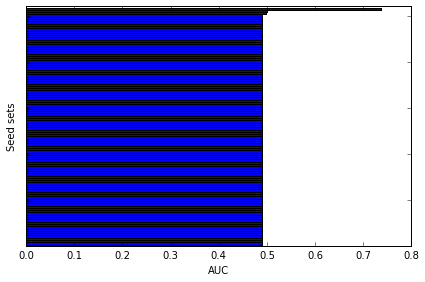

In [18]:
%run func_net_pred 'Dosage Lethality'

Number of genes in functional network: 18031
Number of genes in interactions: 89
Number of seed sets: 15


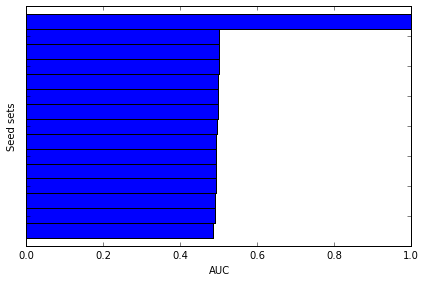

In [20]:
%run func_net_pred 'Dosage Rescue'

Number of genes in functional network: 18031
Number of genes in interactions: 252
Number of seed sets: 203


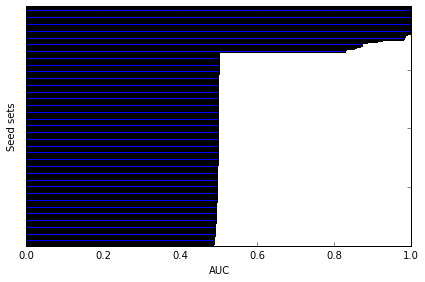

In [21]:
%run func_net_pred 'Phenotypic Enhancement'

Number of genes in functional network: 18031
Number of genes in interactions: 249
Number of seed sets: 182


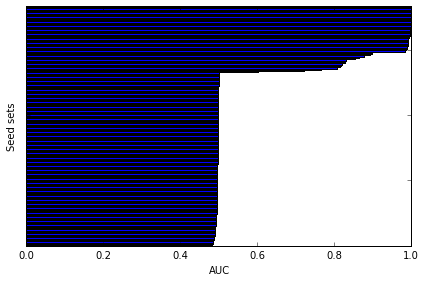

In [22]:
%run func_net_pred 'Phenotypic Suppression'

Number of genes in functional network: 18031
Number of genes in interactions: 152
Number of seed sets: 16


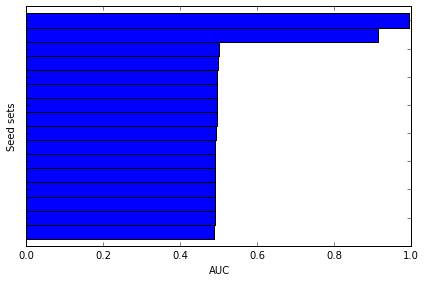

In [23]:
%run func_net_pred 'Synthetic Growth Defect'

In [24]:
%run func_net_pred 'Synthetic Rescue'

Number of genes in functional network: 18031
Number of genes in interactions: 138
Number of seed sets: 16


**2016 January 18-19**

As of today, the download BIOGRID file will be used "as is" instead of using a file containing only the genetic interactions. Considering the appropriate "Experimental System" should be sufficient. 

The *func_net_pred.py* script has been refactored to use Pandas. The gene columns to read in the BIOGRID file are no longer hard-coded; the columns to read are determined from the gene ID used in the functional network. Result agreement with the original method used on BIOGRID v3.4.127 was verified. **_IMPORTANT_**: Initially the results did not agree! The major reason was that the new code did not check whether the seed gene was in the functional network. This was done in the old version with the line `if seedGene in gene2idx:`. It may be worthwhile to examine the effect of interactor set size on predictability. Going forward, there will be no check on whether the seed gene is in the network. 

## Predictability in Non-BIOGRID Datasets

**2016 September 16, 29**

In response to manuscript reviewer comments, the cell-line specific hits from CRISPR screens on human cancer cell lines will serve as seed gene set inputs to the prediction algorithm. The cell-line specific hits are the essential genes for each cell line and are collected in pickled dictionaries. 

First, load the essential genes from the "Identification and characterization of essential genes in the human genome" study. 

In [8]:
aac7041path = os.path.join('..', 'data', 'aac7041essential.pkl')
aac7041 = pickle.load(open(aac7041path, 'rb'))

In [9]:
os.chdir(os.path.join('..', 'src'))

In [10]:
import func_net_pred

In [11]:
fnetpath = os.path.join('..', 'data', 'HumanNetDataFrame.pkl')
funcNetDf = pd.read_pickle(fnetpath)

In [12]:
seedAUC, seed2intacts = func_net_pred.seed_set_predictability(funcNetDf, aac7041)

In [13]:
seedAUC

[(0.48435419440745675, 'Jiyoye'),
 (0.64804438280166432, 'Raji'),
 (0.68150956170125954, 'K562'),
 (0.74129272004127511, 'KBM7')]

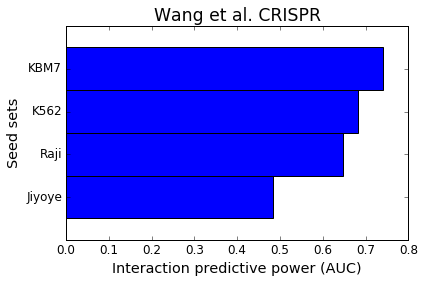

In [20]:
aucs = [t[0] for t in seedAUC]
pos = np.arange(1, len(aucs)+1)
plt.barh(pos, aucs, height=1.0, align='center')
plt.ylim([0, len(aucs)+1])
plt.yticks(np.arange(6), ('', 'Jiyoye', 'Raji', 'K562', 'KBM7', ''))
plt.tick_params(labelsize='large')
plt.xlabel('Interaction predictive power (AUC)', fontsize='x-large')
plt.ylabel('Seed sets', fontsize='x-large')
plt.title('Wang et al. CRISPR', fontsize='xx-large')
plt.tight_layout()
plt.savefig('aac7041predict.pdf', dpi=300)
plt.show()

**2016 September 17**

Next, the Hart et al. CRISPR screen:

In [15]:
hartPath = os.path.join('..', 'data', 'hartEssential.pkl')
hart = pickle.load(open(hartPath, 'rb'))

In [16]:
seedAUC, seed2intacts = func_net_pred.seed_set_predictability(funcNetDf, hart)

In [17]:
seedAUC

[(0.76842149961367312, 'GBM'),
 (0.78045440857137327, 'RPE1'),
 (0.78819818752557069, 'HCT116'),
 (0.79942817798662746, 'HeLa'),
 (0.83887614289735613, 'DLD1')]

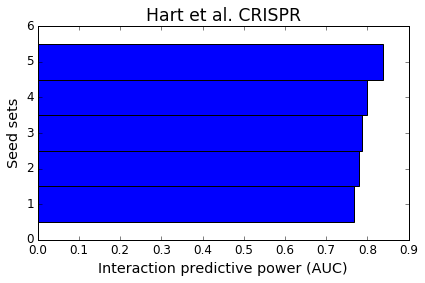

In [18]:
func_net_pred.plot_aucs(seedAUC, 'Hart et al. CRISPR')

## Output Gene Names in Predictive Seed Sets

**2015 August 11**

Entrez IDs have been used for both the BIOGRID genetic interactions and HumanNet; conversion to gene symbols will be needed. Following the approach in the IPython notebook *Fly Genetic Interactions.ipynb*, use the R Bioconductor library *org.Hs.eg.db* (specifically *org.Hs.egSYMBOL*) to output a conversion table to text, which can be read and stored in Python. 

    > library("org.Hs.eg.db")
    > entrezIDs <- ls(org.Hs.egSYMBOL)
    > length(entrezIDs)
    [1] 56340
    > entrezIDs[1:10]
    [1] "1" "2" "3" "9" "10" "11" "12" "13" "14" "15"
    > head(toTable(org.Hs.egSYMBOL[entrezIDs]))
      gene_id symbol
    1       1   A1BG
    2       2    A2M
    3       3  A2MP1
    4       9   NAT1
    5      10   NAT2
    6      11   NATP
    > conversTab <- toTable(org.Hs.egSYMBOL[entrezIDs])
    > write.table(conversTab, file="/work/jyoung/DataProcessed/org.Hs.egSYMBOL.txt",
                  quote=FALSE, sep="\t", row.names=FALSE)

Next, verify that the table has unique gene IDs and read this conversion table into a Python dictionary. 

In [1]:
%%bash
head -5 /work/jyoung/DataProcessed/org.Hs.egSYMBOL.txt

gene_id	symbol
1	A1BG
2	A2M
3	A2MP1
9	NAT1


In [2]:
%%bash
cut -f1 /work/jyoung/DataProcessed/org.Hs.egSYMBOL.txt | sort | uniq | wc -l

56341


In [4]:
entrez2name = dict()
fid = open('/work/jyoung/DataProcessed/org.Hs.egSYMBOL.txt')
header = fid.readline()
for line in fid:
    tokens = line.strip().split('\t')
    entrez2name[tokens[0]] = tokens[1]
fid.close()

Now check whether all of the Entrez IDs in FlyNet are included in the conversion dictionary.

In [5]:
allNetEntrez = set()
for line in open('/work/jyoung/DataDownload/FunctionalNet/H6Net_CC.net'):
    allNetEntrez.update(line.split('\t')[:2])

In [6]:
len(allNetEntrez)

18031

In [7]:
len(allNetEntrez - set(entrez2name.keys()))

0

In [8]:
pickle.dump(entrez2name, open('/work/jyoung/PyPickle/humanEntrez2names.p', 'wb'))

**2015 August 12**

Finally, write out the predictive seed sets.

In [5]:
%run func_net_pred 'Dosage Rescue'

Number of genes in functional network: 18031
Number of genes in interactions: 89
Number of seed sets: 15


In [6]:
%run func_net_pred 'Phenotypic Enhancement'

Number of genes in functional network: 18031
Number of genes in interactions: 252
Number of seed sets: 203


In [7]:
%run func_net_pred 'Phenotypic Suppression'

Number of genes in functional network: 18031
Number of genes in interactions: 249
Number of seed sets: 182


In [8]:
%run func_net_pred 'Synthetic Growth Defect'

Number of genes in functional network: 18031
Number of genes in interactions: 152
Number of seed sets: 16


In [9]:
%run func_net_pred 'Synthetic Rescue'

Number of genes in functional network: 18031
Number of genes in interactions: 138
Number of seed sets: 16


**2016 April 19**

A new version of *org.Hs.egSYMBOL.txt* was created on 2016-04-12. See *Gene ID Conversion in R.ipynb*. Code to write out predictive seed sets is no longer part of *func_net_pred.py*, so the code to do so is below:

In [12]:
# read in conversion dictionary
convertFilepath = os.path.join('..', '..', 'DataProcessed', 'org.Hs.egSYMBOL.txt')
entrez2sym = dict( line.strip().split('\t') for line in open(convertFilepath) )

In [15]:
os.chdir( os.path.join('..', 'src') )

In [16]:
import func_net_pred

In [17]:
biogridpath, fnetpath = func_net_pred.setup_filepaths('sapiens')
funcNetDf = pd.read_pickle(fnetpath)
numNodes = len(funcNetDf.columns)
geneExample = funcNetDf.columns[0]
colName = func_net_pred.determine_col('sapiens', geneExample)

In [18]:
AUCcut = 0.7

In [31]:
def write_predictive_sets(intactType):
    seedSets = func_net_pred.read_biogrid(biogridpath, intactType, colName)
    seedAUC, seed2intacts = func_net_pred.seed_set_predictability(funcNetDf, seedSets)
    
    AUCs = [t[0] for t in seedAUC]
    cutpt = bisect.bisect_left(AUCs, AUCcut)
    
    outputPath = os.path.join('..', 'webapp', 'static', 'Human ' + intactType + ' Seeds.txt')
    outputFile = open(outputPath, 'w')
    for i in range(cutpt, len(AUCs)):
        auc = seedAUC[i][0]
        seedGene = seedAUC[i][1]
        try:
            entrezSeed = entrez2sym[ seedGene ]
        except:
            continue
        outputFile.write('AUC = {:.2f}\t'.format(auc))
        outputFile.write(entrezSeed + ': ')
        entrezIntacts = [entrez2sym[g] for g in seed2intacts[seedGene]]
        outputFile.write(','.join(entrezIntacts) + '\n')
    outputFile.close()

In [28]:
write_predictive_sets('Phenotypic Enhancement')

In [32]:
write_predictive_sets('Phenotypic Suppression')

---

**2015 September 22, 24, 28**

Compare using HumanNet version 2 vs version 1 by plotting the seed set AUCs of version 2 against version 1 for each genetic interaction type. Create a script named *compare_func_net_versions.py* for this purpose.

NOTE: *func_net_pred.py* now accepts 2 command line arguments, the BIOGRID interaction type and the organism. The modified code reduces hard-coded filenames inside individual functions. 

**2015 September 24, 28**

The function *process_func_net( )* assumes that the genes are in columns 1 & 2 and the LLS is in column 3, as it seems must functional networks are in this format. However, HumanNet v1 has the LLS in column 24, so write a new HumanNet v1 file that only has 3 columns with the LLS in column 3:

    cd /work/jyoung/DataDownload/FunctionalNet
    awk '{print $1 "\t" $2 "\t" $24}' HumanNet.v1.join.txt > humannet1.entrez.txt


In [7]:
%run compare_func_net_versions.py 'Phenotypic Enhancement' 1 2

Number of genes in interactions: 252


Number of genes in interactions: 249


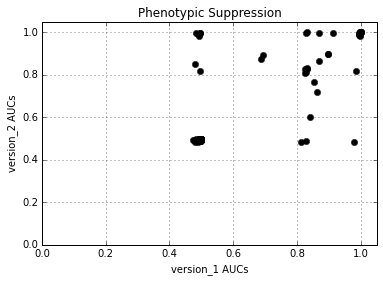

In [8]:
%run compare_func_net_versions.py 'Phenotypic Suppression' 1 2

**2015 November 29-30**

Updated *proteincomplexformat.py* to process downloaded CORUM file into a 2-column format. Unfortunately, it will not be possible to directly process the CORUM file into Entrez IDs. See *Gene ID Conversion.ipynb* for details. 2-column format written by *proteincomplexformat.py* as *CORUM_Human_Entrez.txt*. 

Using *clust_intact.py* at 5% FDR by Benjamini-Hochberg, there were no significant within-complex interactions of out 1618 protein complexes. The background probabilities were: 0.117 (Dosage Growth Defect), 0.0177 (Dosage Lethality), 0.0159 (Dosage Rescue), 0.667 (Negative Genetic), 0.00609 (Phenotypic Enhancement), 0.00671 (Phenotypic Suppression), 0.00453 (Synthetic Growth Defect), 0.00580 (Synthetic Lethality), 0.0119 (Synthetic Rescue).  

For between-complex interactions, there was also no significance from examining 1308153 complex pairs for each interaction type. 

## Network with Pandas

**2016 January 17**

For execution speed purposes, the Pandas dataframe representation of the functional gene network will be pre-computed and pickled. 

In [4]:
fnetpath = os.path.join('..', '..', 'DataDownload', 'FunctionalNet', 'H6Net_CC.net')

In [5]:
G = nx.read_weighted_edgelist(fnetpath, delimiter='\t')
funcDF = nx.to_pandas_dataframe(G)

In [6]:
funcDF.to_pickle(os.path.join('..', 'data', 'HumanNetDataFrame.pkl'))